<a id="top-of-page"></a>
# Table of Contents #
Click on a chapter:<br>
**[1. Subtask 5: Sentiment Analysis](#subtask5)<br>**
[a. Data Pre-processing](#1-preprocessing)<br>
[b. Additional Exploratory Data Analysis](#2-eda)<br>
[c. Sentiment Analysis: Reviews Text](#3-review-text-analysis)<br>
[d. Sentiment Analysis](#4-sentiment-analysis)<br>
[di. Feature Extraction](#4a)<br>
[dii. Sentiment Classifier](#4b)<br>
[diii. Results and Visualisation](#4c)<br>
**[2. Conclusion](#2-conclusion)<br>**
**[3. References](#3-references)<br>**
**[4. Overall Conclusion](#4-conclusion)<br>**

<a id="subtask5"></a>
# 1. Subtask 5: Sentiment Analysis #

Sentiment analysis is a critical aspect of data analytics and has become increasingly important in today's digital world (Li, 2018). It involves the use of natural language processing and machine learning techniques to extract and analyse emotions and opinions expressed in written or spoken text. Sentiment analysis is essential for businesses to understand customer attitudes and opinions towards their products, services, or brand. By analysing sentiment data, businesses can gain valuable insights into customer behavior, identify areas of improvement, and enhance their overall customer experience. It can also help businesses to identify potential issues early, allowing them to take proactive measures to address them. Furthermore, sentiment analysis can be used to monitor brand reputation, analyse customer feedback, and gain insights into the effectiveness of marketing campaigns (Gupta, 2018). Overall, sentiment analysis provides a powerful tool for businesses to stay ahead of the curve and make data-driven decisions that can improve customer satisfaction and drive growth.

Sentiment analysis techniques can be divided into two categories: rule-based and machine learning-based. Rule-based approaches rely on pre-defined rules and dictionaries of words associated with positive or negative sentiment and assign a sentiment score based on the presence of these words in the text. Machine learning-based approaches, on the other hand, use algorithms to learn from labelled training data and then classify the sentiment of new, unseen text data. The group decided to use the ML approach; however, first, we will perform some additional analysis of the reviews dataset.

In [64]:
# Import statements
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import unicodedata
import string
from googletrans import Translator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

# NLTK tools for text processing
import re, nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
nltk.download('stopwords')
from string import punctuation
from nltk.probability import FreqDist
from collections import defaultdict
from heapq import nlargest
from nltk.stem import PorterStemmer

# Modelling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from sklearn.decomposition import TruncatedSVD

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bisis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bisis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<a id="1-preprocessing"></a>
## a) Data Pre-processing ##

First, we will import the dataset and deal with NaN values, as discussed in Subtask 1.

In [27]:
# load reviews data file drop NaN values
order_reviews_data = pd.read_csv('data/olist_order_reviews_dataset.csv', encoding='ISO-8859-1')
order_reviews_data.shape

(100000, 7)

In [28]:
# drop na values from review_comment_title and review_comment_message 
order_reviews_data_message_dropna = order_reviews_data.dropna(subset=['review_comment_message'])
order_reviews_data_title_dropna = order_reviews_data.dropna(subset=['review_comment_title'])

# Reset indexing to prevent errors
order_reviews_data_message_dropna = order_reviews_data_message_dropna.reset_index(drop=True)

print(order_reviews_data_message_dropna.shape) # print to validate
print(order_reviews_data_title_dropna.shape) # print to validate

(41744, 7)
(11715, 7)


_[Go to top](#top-of-page)_

<a id="2-eda"></a>
## b) Additional Exploratory Data Analysis ##
In Subtask 1, we performed an extensive analysis of the review dataset, and we carry that knowledge to this subtask as well. However, there are some additional behaviours that we will investigate now.

To gain more insights into the correlation between customers who gave low or high review scores and those who have provided feedback, we will plot the following:

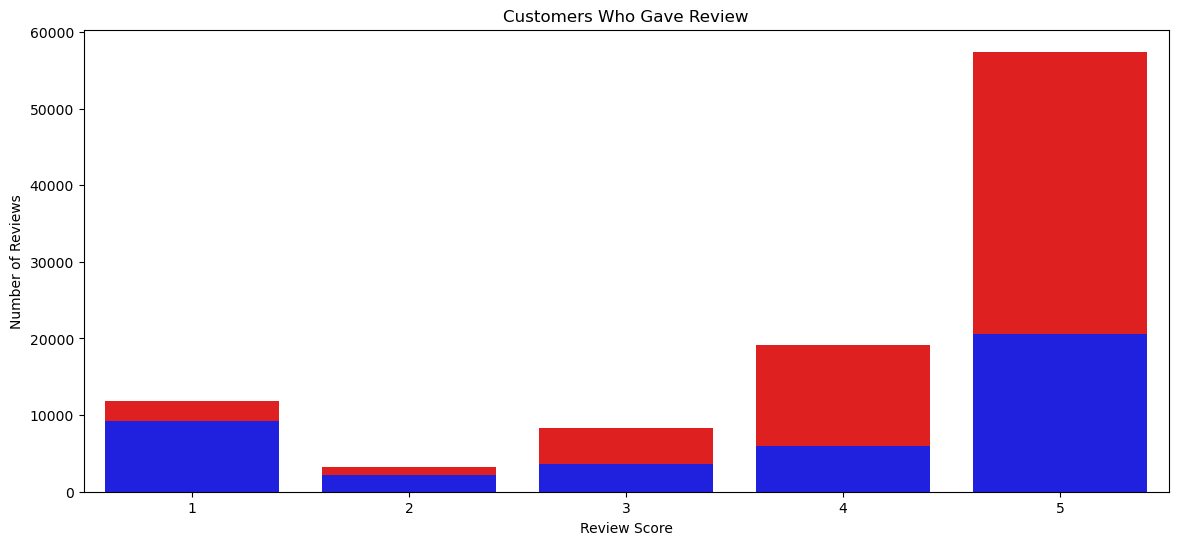

In [29]:
# Plot customers who gave review before and after dropping NaN
plt.figure(figsize=(14,6))
sns.countplot(x=order_reviews_data['review_score'], color='red') # Nan included
sns.countplot(x=order_reviews_data_message_dropna['review_score'], color='blue') # Nan excluded
plt.title('Customers Who Gave Review')
plt.xlabel('Review Score')
plt.ylabel('Number of Reviews')
plt.show();

Before removing NaN values (red), the plot shows that almost 60k people gave 5-star reviews while a little over 10k gave 1-star reviews. From the plot, after removing NaN values (blue), we can see that almost 10k people gave 1-star reviews while over 20k gave 5-star reviews.

This means that about 36% of 5-star reviewers gave reviews while 79% of 1-star reviewers gave reviews; therefore, an **unsatisfied customer (1-star) is more likely to give a review**. <br><br>

Next, we will look at how many words there are per review and the average number of words in a review. This knowledge can be helpful in sentiment analysis, especially when assessing review quality and emotional content. Longer reviews indicate that customers are taking more time to write thoughtful, detailed reviews, which is a sign of high-quality feedback. Longer reviews may also contain more emotional content, which could help identify sentiment. For example, if a longer review contains many positive or negative words, it may be easier to classify the review's sentiment.

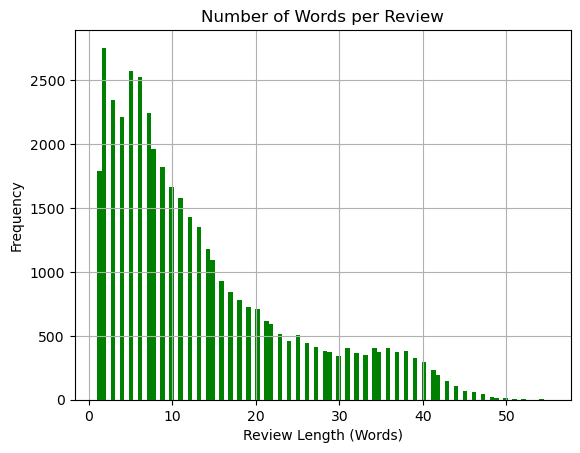

In [30]:
# Plot number of words per review
words_per_review = order_reviews_data_message_dropna.review_comment_message.apply(lambda x: len(x.split(" "))) # split reviews
words_per_review.hist(bins = 100, color='green', align='mid')
plt.xlabel('Review Length (Words)')
plt.ylabel('Frequency')
plt.title('Number of Words per Review')
plt.show();

Average words: 13.361081832119586


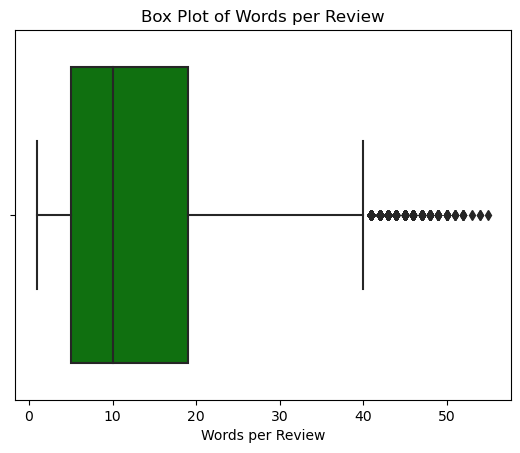

In [31]:
# Get average number of words per review and plot
print('Average words:', words_per_review.mean())
sns.boxplot(x=words_per_review, color='green')
plt.xlabel('Words per Review')
plt.title('Box Plot of Words per Review')
plt.show();

We can see that the average number of words per review is 13, but the data is positively skewed, so the mean of the distribution is greater than the median, and some unusually large values pull the mean to the right. The total number of words (number of words per review) seems suitable to be used in an ML-based Sentiment Analysis.

Next, let's explore the word counts per review score to understand the behaviour of satisfied/unsatisfied customers in writing a review.

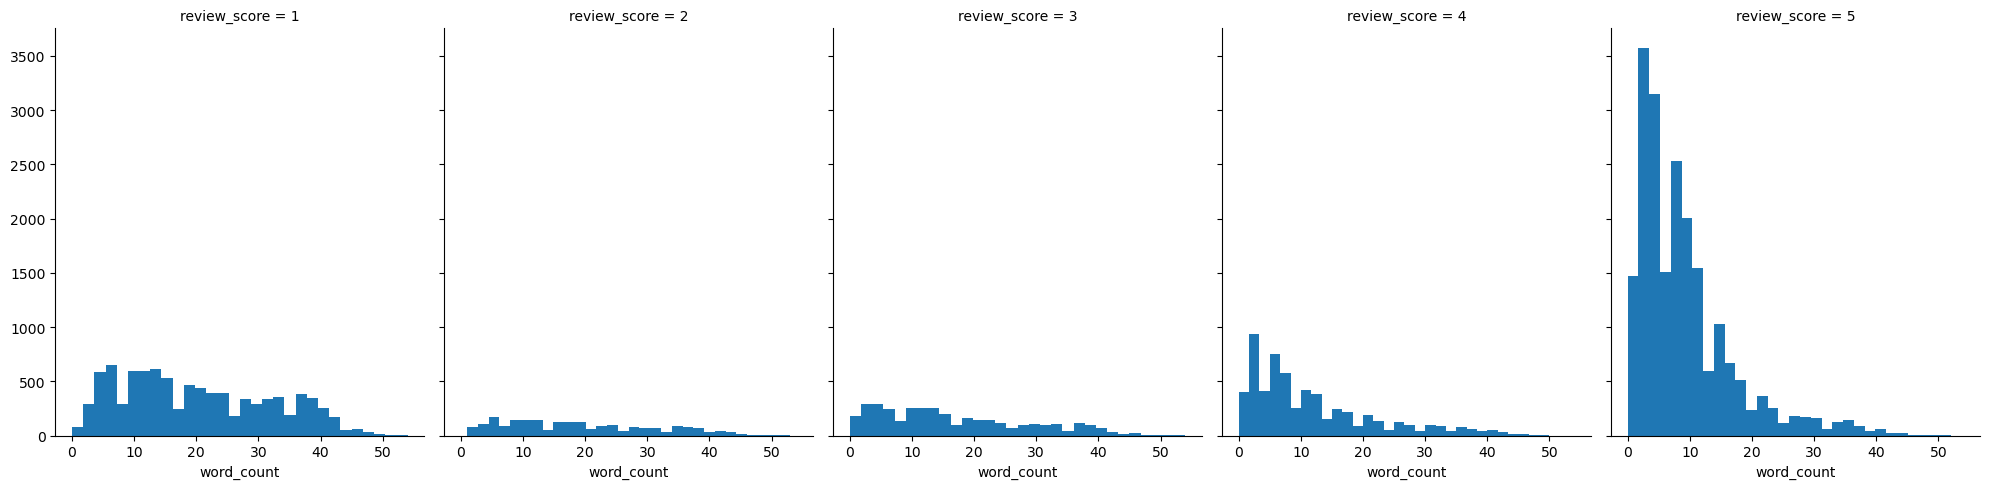

In [32]:
# Grid chart of word counts per review
order_reviews_data_message_dropna.loc[:, 'word_count'] = order_reviews_data_message_dropna['review_comment_message'].apply(lambda x: len(str(x).split()))
order_reviews_data_message_dropna.word_count.max()
g = sns.FacetGrid(data=order_reviews_data_message_dropna, col='review_score',height=5, aspect=0.8)
before_remove = g.map(plt.hist, 'word_count', bins=30)
before_remove
plt.show();

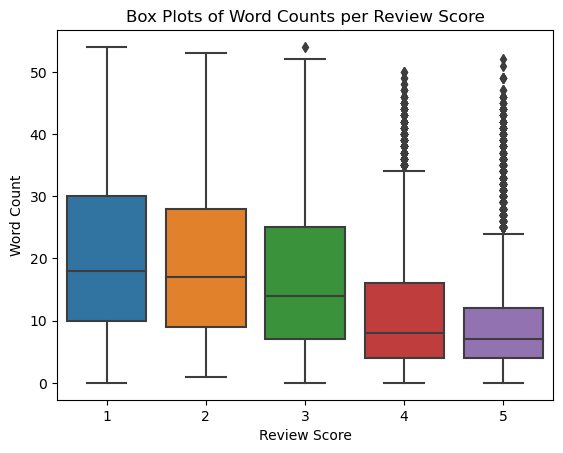

In [33]:
# Boxplots word counts per review score
sns.boxplot(x='review_score', y='word_count', data=order_reviews_data_message_dropna)
plt.xlabel('Review Score')
plt.ylabel('Word Count')
plt.title('Box Plots of Word Counts per Review Score')
plt.show();

The box plots and the grid chart above shows that **the higher the score, the fewer words in a review**. This supports the everyday human behaviour where people tend to talk more when unsatisfied or unhappy. 

We now know the word counts per review score; we will now attempt to visualise words used per review score using a word cloud.

In [34]:
stop = stopwords.words('english')
stop.append('nao')

# Create function to use for each rating (1 to 5)
def visualise(label):
    words = ''
    for msg in order_reviews_data_message_dropna[order_reviews_data_message_dropna['review_score'] == label]['review_comment_message']:
        msg = msg.lower()
        words += msg + ' '
    wordcloud = WordCloud(width = 2000, height = 1000, background_color='white').generate(words)
    plt.figure(figsize=(8,4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Review Comment Word Cloud for Review Rating ' + str(label))
    plt.show();

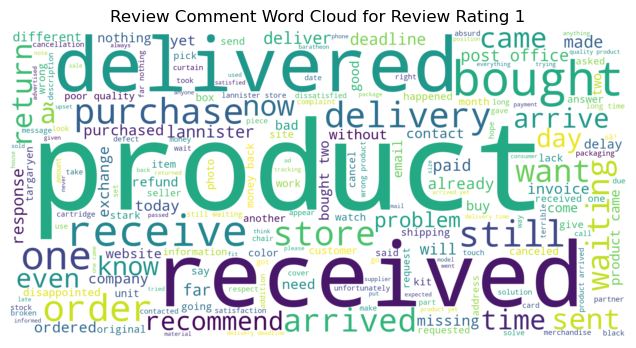

In [35]:
visualise(1) # wordcloud for 1-star reviews

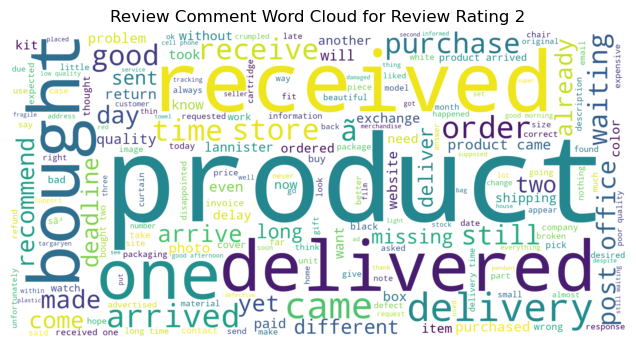

In [36]:
visualise(2) # wordcloud for 2-star reviews

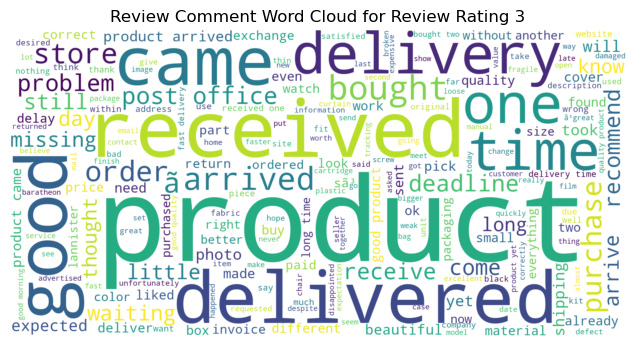

In [37]:
visualise(3) # wordcloud for 3-star reviews

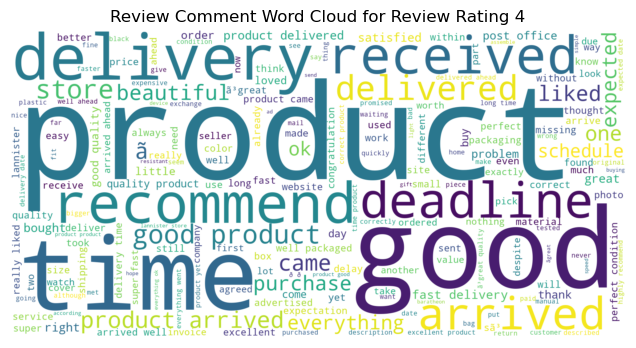

In [38]:
visualise(4) # wordcloud for 4-star reviews

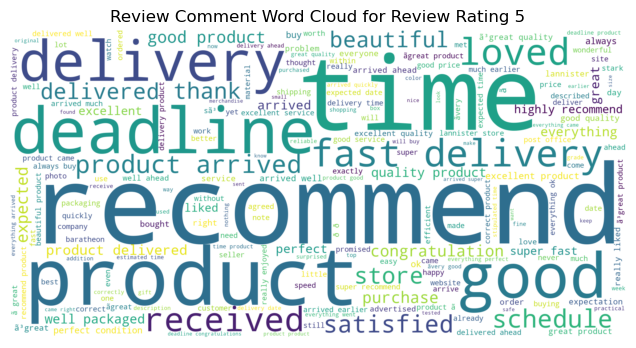

In [39]:
visualise(5) # wordcloud for 5-star reviews

We can see the recurring words in all review scores, including product, delivery, received, etc. We can also see some words that are to be expected in regard to the review score:
* 1-star: waiting, still, return, delay, missing, late, defect
* 2-star: waiting, quality
* 3-star: delivered, good, received, problem, little
* 4-star: time, delivered, recommend, good, satisfied
* 5-star: recommend (very frequent), good, deadline, loved, congratulation, satisfied, fast delivery, etc. <br>

These results are to be expected. Something to note here would be that it seems people were mostly commenting on the overall shopping experience (including the communication with the seller and the delivery) rather than the actual product. This occurs in real life, as customers are prompt to give feedback almost as soon as it arrives. At that stage, however, they are unlikely to comment on the actual product, its usage or its durability.

_[Go to top](#top-of-page)_

<a id="3-review-text-analysis"></a>
## c) Sentiment Analysis: Reviews Text ##

The next steps in sentiment analysis involve the following:
* Remove stop words
* Use the RegEx module to accept only letters
* Tokenization
* Make all words lowercase
* Remove accentuation
* Remove punctuation and numbers <br>

The group decided on these steps for the following reasons. In a sentiment analysis task, stop words such as "the" or "and" are unlikely to contribute much to determine the sentiment of a text. Removing these stop words can reduce noise in the data and improve the accuracy of the sentiment analysis. <br>
Tokenization is used in natural language processing to split paragraphs and sentences into smaller units that can be more easily assigned meaning. We are also making all words lowercase to achieve consistency.

In [40]:
comments_messages = [] # empty list to hold comments extracted from a text corpus
stop_words = set(stopwords.words('english')) # NLTK English stopwords

for words in order_reviews_data_message_dropna['review_comment_message']:
    words = unicodedata.normalize('NFKD', words).encode('ASCII', 'ignore').decode('ASCII') # remove accentuation
    words = words.translate(str.maketrans('', '', string.punctuation + string.digits)) # remove punctuation and numbers
    tokens = nltk.word_tokenize(words) # tokenize the sentences
    lower_case = [l.lower() for l in tokens] # convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) # remove stopwords from the comments
    comments_messages.append(' '.join(filtered_result))

Next, we will visualise the findings.

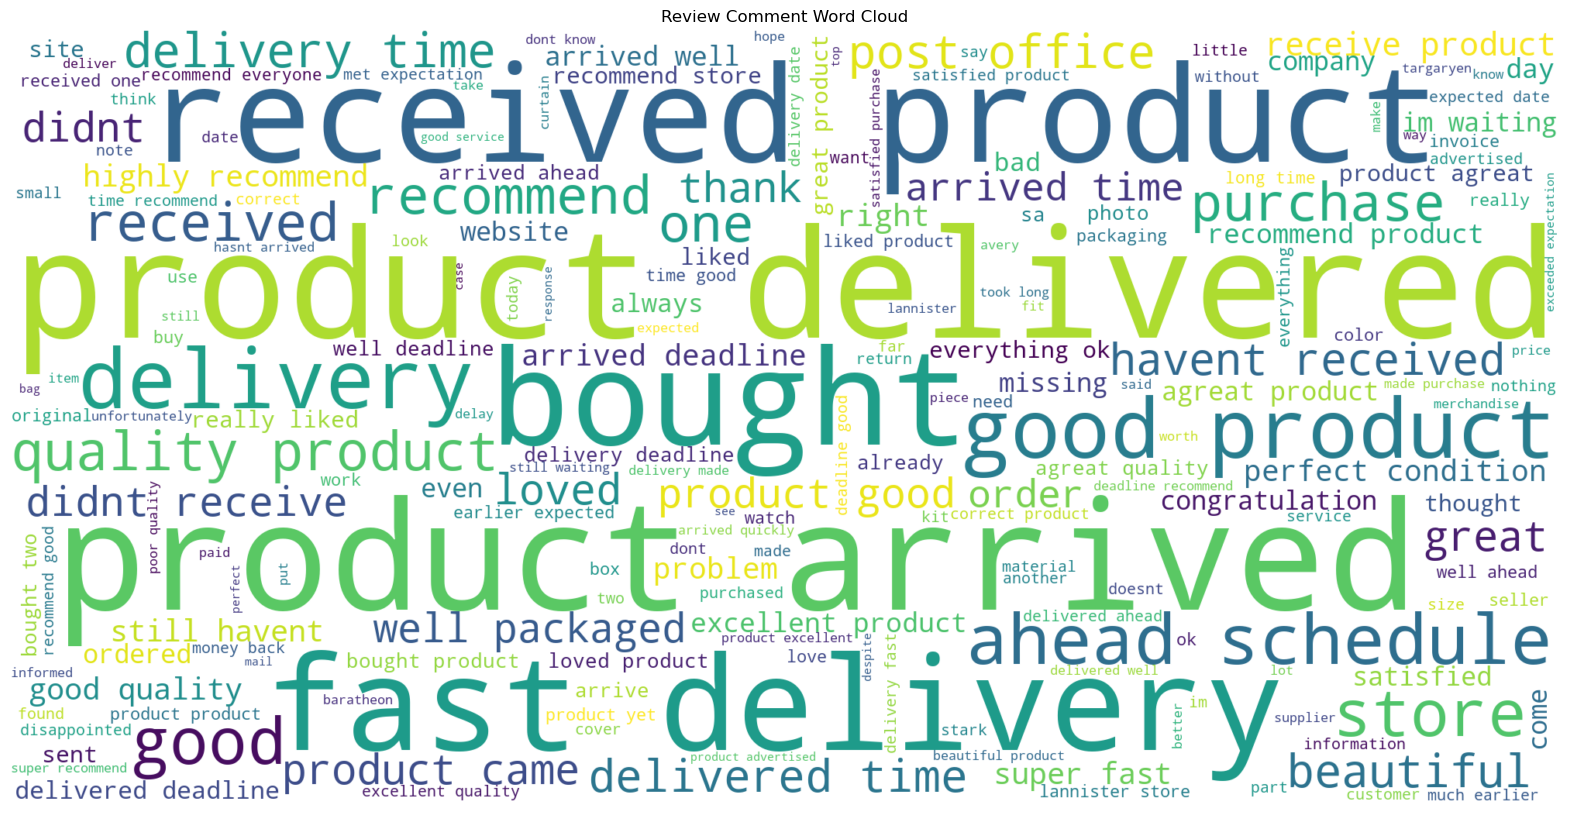

In [41]:
# visualise the comments list (wordcloud)
unique_string=(" ").join(comments_messages)
wordcloud = WordCloud(width = 2000, height = 1000, background_color='white').generate(unique_string)
plt.figure(figsize=(20,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Review Comment Word Cloud')
plt.show();

At first glance, we can see positive words such as 'product arrived', 'fast delivery', 'good product', and 'ahead schedule'. Overall, the language seems to be more positive than negative. This correlates with findings from Subtask 1: Exploratory Data Analysis, where we found that 57.4% of reviews were 5 stars.

Next, we will extract the most frequent one words, two words and three words: **unigrams**, **bigrams**, and **trigrams**. <br>

Unigrams, bigrams, and trigrams are useful in sentiment analysis because they capture different levels of context and meaning in the text. For example, unigrams are useful for identifying individual words with positive or negative sentiments, such as "good" or "bad". Bigrams and trigrams can provide more context and help to identify sentiment in longer phrases or sentences. <br>

Using n-grams in sentiment analysis can improve the accuracy of the analysis by capturing more nuances of language and context. N-grams can also help to identify common phrases and language patterns associated with positive or negative sentiment, which can be helpful in developing more accurate and efficient sentiment analysis models.

In [42]:
# get the most important unigrams (CountVectorizer)
co = CountVectorizer(ngram_range=(1,1)) # unigrams
counts = co.fit_transform(comments_messages)
important_trigrams = pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names_out()).T.sort_values(0,ascending=False)
important_trigrams=important_trigrams.reset_index() # reset index
important_trigrams.rename(columns={'index':'unigrams',0:'frequency'},inplace=True) # rename columns
important_trigrams.head(40) # show results

unigrams  frequency
0      product      18886
1     delivery       6500
2         good       6196
3      arrived       5665
4     received       5047
5         time       4981
6    delivered       4908
7    recommend       4695
8     deadline       3294
9         came       3099
10      bought       2987
11     quality       2774
12         one       2490
13        fast       2463
14        well       2426
15       store       2388
16       didnt       2186
17    purchase       1990
18  everything       1741
19   excellent       1709
20      agreat       1616
21    expected       1596
22       order       1562
23     receive       1549
24       great       1542
25   beautiful       1530
26        like       1517
27       loved       1491
28          im       1452
29      havent       1410
30     perfect       1378
31         buy       1373
32       still       1373
33   satisfied       1334
34    products       1331
35       ahead       1302
36       liked       1257
37    schedule       1248
38       super       1223
39       would       1137

We are displaying the 40 most frequent one words occurring in the dataset. These give us a high-level understanding; we can clearly see words such as 'good', 'recommend' or 'received' being used frequently. However, for deeper understanding, we will examine the two and three words.

In [43]:
# get the most important bigrams (CountVectorizer)
co = CountVectorizer(ngram_range=(2,2)) # bigrams
counts = co.fit_transform(comments_messages)
important_trigrams = pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names_out()).T.sort_values(0,ascending=False)
important_trigrams=important_trigrams.reset_index() # reset index
important_trigrams.rename(columns={'index':'bigrams',0:'frequency'},inplace=True) # rename columns
important_trigrams.head(40) # show results

bigrams  frequency
0    product delivered       1899
1      product arrived       1858
2        fast delivery       1400
3     received product       1397
4       ahead schedule       1233
5         good product       1058
6        delivery time        931
7          post office        873
8      quality product        872
9       delivered time        848
10     havent received        835
11        product came        740
12       didnt receive        722
13       well packaged        710
14        arrived time        684
15     receive product        601
16          super fast        565
17    highly recommend        562
18        still havent        554
19        good quality        550
20    arrived deadline        544
21   perfect condition        527
22   excellent product        521
23        arrived well        513
24        product good        495
25          im waiting        467
26      agreat product        414
27  delivered deadline        388
28    product delivery        386
29        really liked        383
30       everything ok        378
31     recommend store        376
32          would like        368
33       well deadline        361
34   delivery deadline        356
35          bought two        356
36          didnt like        354
37       arrived ahead        351
38      product agreat        346
39      agreat quality        343

The two-words are quite helpful; we see the pattern of customers commenting on the delivery time, packaging and product condition and quality. The overall consensus seems to be that products are good quality and they arrived quickly. Next, let's see if this is still supported by the three-words.

In [44]:
# get the most important trigrams (CountVectorizer)
co = CountVectorizer(ngram_range=(3,3)) # trigrams
counts = co.fit_transform(comments_messages)
important_trigrams = pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names_out()).T.sort_values(0,ascending=False)
important_trigrams=important_trigrams.reset_index() # reset index
important_trigrams.rename(columns={'index':'trigrams',0:'frequency'},inplace=True) # rename columns
important_trigrams.head(40) # show results

trigrams  frequency
0        still havent received        470
1       product delivered time        454
2      havent received product        420
3        didnt receive product        360
4       arrived ahead schedule        336
5          super fast delivery        321
6          well ahead schedule        298
7         product arrived time        284
8     delivered ahead schedule        226
9         good quality product        193
10      product agreat quality        183
11       product fast delivery        175
12             would like know        170
13        product arrived well        167
14       product arrived ahead        166
15       arrived well deadline        164
16            pick post office        156
17     product delivered ahead        153
18  product delivered deadline        140
19    arrived earlier expected        137
20     delivery ahead schedule        132
21          arrived well ahead        124
22    product arrived deadline        123
23       much earlier expected        120
24        really liked product        119
25              took long time        118
26        received product yet        117
27       fast delivery product        116
28            im still waiting        114
29             want money back        113
30        arrived much earlier        109
31   arrived perfect condition        107
32       product well packaged        104
33          came well packaged         98
34       product delivery time         98
35   excellent quality product         95
36          time well packaged         90
37      product delivered well         83
38        product good quality         82
39       product yet delivered         81

The overall opinions of the customers hold when examining the three-words, if anything, we can now see that the delivery was not only fast, it was also well ahead delivery deadline very often.<br>
On the other hand, some negative phrases occur within the results now: 'took a long time', and 'want the money back'. However, these are less frequent than the seemingly positive comments. Most customers were satisfied with the delivery service and some others were satisfied with the product quality or packaging.

Next, we will perform the same steps for the **review titles**.

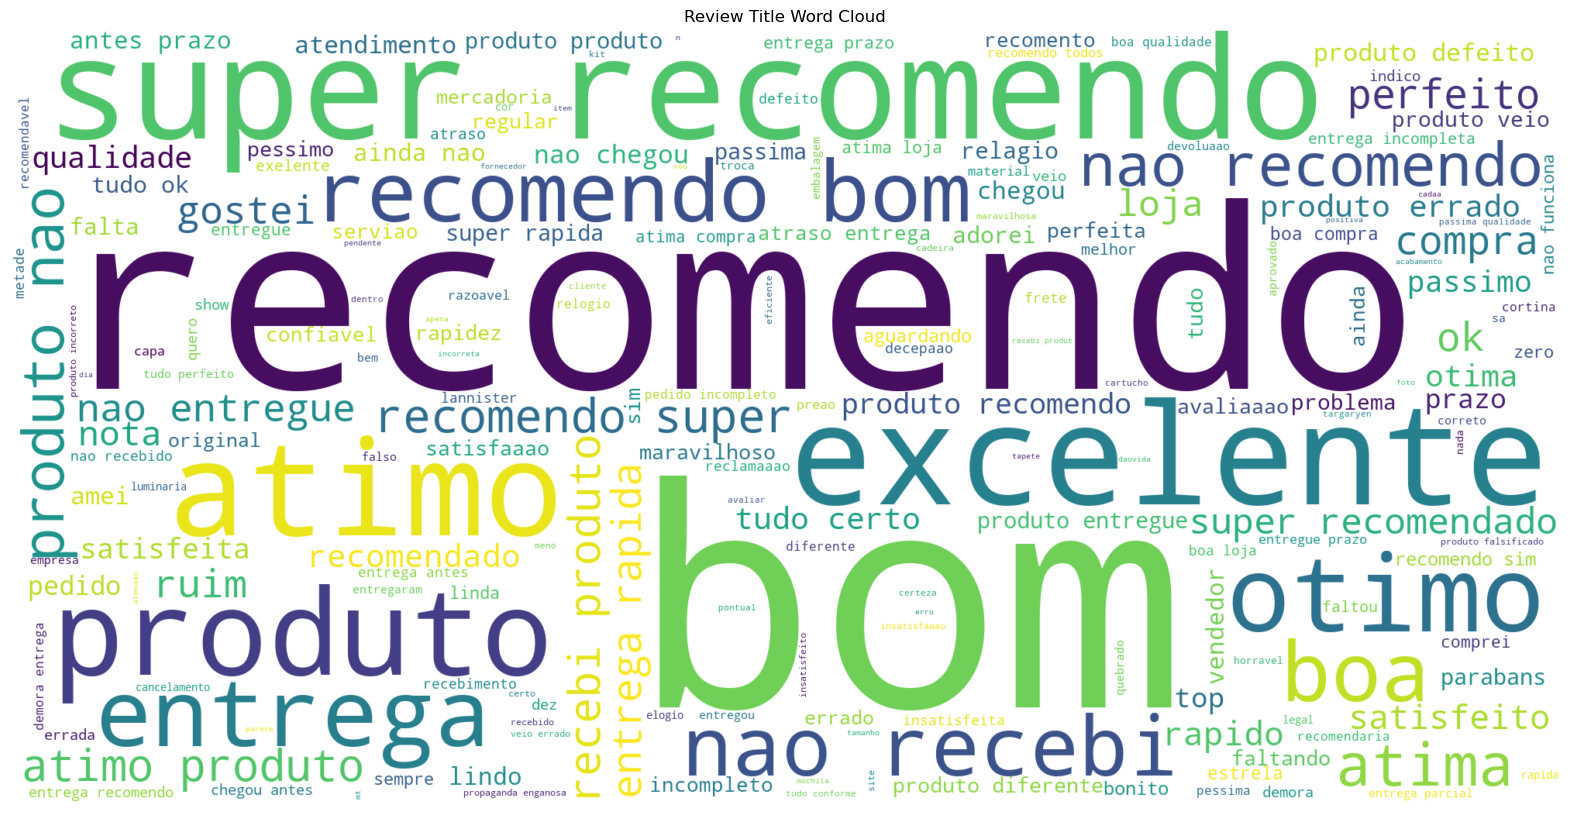

In [45]:
comments_titles = [] # empty list to hold comments extracted from a text corpus
stop_words = set(stopwords.words('portuguese')) # NLTK Portuguese stopwords
    
for words in order_reviews_data_title_dropna['review_comment_title']:
    words = unicodedata.normalize('NFKD', words).encode('ASCII', 'ignore').decode('ASCII') # remove accentuation
    words = words.translate(str.maketrans('', '', string.punctuation + string.digits)) # remove punctuation and numbers
    tokens = nltk.word_tokenize(words) # tokenize the sentences
    lower_case = [l.lower() for l in tokens] # convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) # remove stopwords from the comments
    comments_titles.append(' '.join(filtered_result))
    
# visualise the comments list (wordcloud)
unique_string=(" ").join(comments_titles)
wordcloud = WordCloud(width = 2000, height = 1000,background_color='white').generate(unique_string)
plt.figure(figsize=(20,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Review Title Word Cloud')
plt.show();

We can see that, unlike the review messages, the titles were not translated into English. However, we can still deduct that words used include 'excellent', 'recommend', 'on time', etc. Therefore, the titles are similarly positive as the review comment messages. <br>

For the next exercise, we will attempt to translate the titles using Google Translate API and the Googletrans library; however, as the API has some limitations on the number of translations that can be made in a day, we will only translate the 40 results per n-gram.

In [46]:
# get the most important unigrams (CountVectorizer)
co = CountVectorizer(ngram_range=(1,1)) # unigrams
counts = co.fit_transform(comments_titles)
important_unigrams_title = pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names_out()).T.sort_values(0,ascending=False)
important_unigrams_title=important_unigrams_title.reset_index() # reset index
important_unigrams_title.rename(columns={'index':'unigrams',0:'frequency'},inplace=True) # rename columns
important_unigrams_title.head(40) # show results

unigrams  frequency
0     recomendo       2080
1       produto       1325
2           bom       1319
3         super        900
4           nao        832
5         atimo        726
6     excelente        663
7       entrega        541
8         otimo        368
9        recebi        302
10          boa        272
11        atima        217
12         tudo        192
13     entregue        183
14  recomendado        180
15       rapida        168
16           ok        157
17       compra        151
18        prazo        150
19         loja        133
20     perfeito        132
21       chegou        126
22         nota        110
23       errado        108
24         ruim        107
25       gostei        105
26    qualidade        100
27   satisfeito         90
28        certo         86
29         veio         86
30       rapido         83
31      defeito         78
32        ainda         75
33        otima         75
34       pedido         71
35      passimo         69
36   satisfeita         66
37        antes         65
38          top         63
39          sim         53

Let's translate the 40 results to understand the output.

In [47]:
# Translate results (40) to English
important_unigrams_title_to_translate = important_unigrams_title.iloc[:40][['unigrams']]
translator = Translator() # instance of Translator
important_unigrams_title_to_translate['unigrams_en'] = important_unigrams_title_to_translate['unigrams'].apply(lambda x: translator.translate(x, dest='en').text)
important_unigrams_title_to_translate # view translations

unigrams  unigrams_en
0     recomendo  I recommend
1       produto      product
2           bom          bom
3         super        super
4           nao          nao
5         atimo    vigilance
6     excelente        great
7       entrega     delivery
8         otimo    excellent
9        recebi   I received
10          boa          boa
11        atima   takes away
12         tudo          all
13     entregue    delivered
14  recomendado  recommended
15       rapida        rapid
16           ok           ok
17       compra     purchase
18        prazo         term
19         loja        store
20     perfeito      perfect
21       chegou   it arrived
22         nota          use
23       errado        wrong
24         ruim        roomy
25       gostei      I liked
26    qualidade      quality
27   satisfeito    satisfied
28        certo        right
29         veio      he came
30       rapido        rapid
31      defeito       defect
32        ainda          yet
33        otima      abducts
34       pedido        order
35      passimo      pass up
36   satisfeita    satisfied
37        antes       before
38          top          top
39          sim          sim

In [48]:
# get the most important bigrams (CountVectorizer)
co = CountVectorizer(ngram_range=(2,2)) # bigrams
counts = co.fit_transform(comments_titles)
important_bigrams_title = pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names_out()).T.sort_values(0,ascending=False)
important_bigrams_title=important_bigrams_title.reset_index() # reset index
important_bigrams_title.rename(columns={'index':'bigrams',0:'frequency'},inplace=True) # rename columns
important_bigrams_title.head(40) # show results

bigrams  frequency
0      super recomendo        680
1           nao recebi        215
2        nao recomendo        179
3          produto nao        136
4       recebi produto        131
5       entrega rapida        116
6         nao entregue        108
7        atimo produto        103
8    super recomendado        103
9          bom produto         76
10          tudo certo         75
11      produto errado         74
12         produto bom         65
13          nao chegou         53
14     produto defeito         52
15           ainda nao         49
16         antes prazo         48
17             tudo ok         45
18    produto entregue         40
19   excelente produto         37
20        super rapida         36
21        produto veio         33
22       entrega super         33
23   produto diferente         28
24       otimo produto         27
25      atraso entrega         26
26   produto excelente         25
27          boa compra         21
28          atima loja         21
29      recomendo loja         21
30       entrega prazo         21
31        nao funciona         21
32        atima compra         20
33       recomendo sim         20
34  entrega incompleta         19
35          nao gostei         18
36        chegou antes         18
37        nao recebido         17
38       entrega antes         17
39    excelente compra         17

In [49]:
# Translate results (40) to English
important_bigrams_title_to_translate = important_bigrams_title.iloc[:40][['bigrams']]
translator = Translator() # instance of Translator
important_bigrams_title_to_translate['bigrams_en'] = important_bigrams_title_to_translate['bigrams'].apply(lambda x: translator.translate(x, dest='en').text)
important_bigrams_title_to_translate # view translations

bigrams           bigrams_en
0      super recomendo      super recommend
1           nao recebi         not received
2        nao recomendo   I do not recommend
3          produto nao           no product
4       recebi produto   I received product
5       entrega rapida        fast delivery
6         nao entregue        not delivered
7        atimo produto            prosecute
8    super recomendado    super recommended
9          bom produto         good product
10          tudo certo        all very well
11      produto errado        wrong product
12         produto bom         good product
13          nao chegou       did not arrive
14     produto defeito    defective product
15           ainda nao              not yet
16         antes prazo               rather
17             tudo ok     everything is OK
18    produto entregue    product delivered
19   excelente produto    excellent product
20        super rapida          super quick
21        produto veio         Product came
22       entrega super       Super delivery
23   produto diferente    different product
24       otimo produto        great product
25      atraso entrega       delay delivery
26   produto excelente    excellent product
27          boa compra         good bargain
28          atima loja        deprives Loya
29      recomendo loja    I recommend store
30       entrega prazo             delivery
31        nao funciona        does not work
32        atima compra       ATIMA PURCHASE
33       recomendo sim      I recommend yes
34  entrega incompleta  incomplete delivery
35          nao gostei         did not like
36        chegou antes       arrived before
37        nao recebido         not received
38       entrega antes      Delivery before
39    excelente compra   excellent purchase

In [50]:
# get the most important trigrams (CountVectorizer)
co = CountVectorizer(ngram_range=(3,3)) # trigrams
counts = co.fit_transform(comments_titles)
important_trigrams_title = pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names_out()).T.sort_values(0,ascending=False)
important_trigrams_title=important_trigrams_title.reset_index() # reset index
important_trigrams_title.rename(columns={'index':'trigrams',0:'frequency'},inplace=True) # rename columns
important_trigrams_title.head(40) # show results

trigrams  frequency
0        nao recebi produto        105
1      produto nao entregue         70
2      entrega super rapida         33
3          ainda nao recebi         28
4       entrega antes prazo         15
5        produto nao chegou         15
6      produto nao recebido         13
7      produto nao funciona         11
8        chegou antes prazo         11
9         nao recebi produt          9
10         ainda nao chegou          9
11   produto entregue prazo          8
12    produto boa qualidade          8
13       nao chegou produto          7
14     produto veio defeito          7
15      produto veio errado          7
16        nao recebi pedido          6
17        produto ainda nao          6
18  produto entregue errado          5
19     entrega dentro prazo          5
20   produto diferente foto          5
21      pedido nao entregue          5
22     entregue antes prazo          5
23    recebi produto errado          5
24         nao recebi ainda          5
25          bem antes prazo          4
26       nao gostei produto          4
27        nao posso avaliar          4
28         nao chegou prazo          4
29     produto nao original          4
30       recebi antes prazo          4
31    atimo custo benefacio          4
32  mercadoria nao entregue          4
33   produto veio diferente          4
34      bom custo benefacio          4
35       produto nao condiz          3
36        nao quero avaliar          3
37    atimo custo beneficio          3
38      nao entrega produto          3
39          recebi sa itens          3

In [51]:
# Translate results (40) to English
important_trigrams_title_to_translate = important_trigrams_title.iloc[:40][['trigrams']]
translator = Translator() # instance of Translator
important_trigrams_title_to_translate['trigrams_en'] = important_trigrams_title_to_translate['trigrams'].apply(lambda x: translator.translate(x, dest='en').text)
important_trigrams_title_to_translate # view translations

trigrams                    trigrams_en
0        nao recebi produto  I did not recieve the product
1      produto nao entregue          product not delivered
2      entrega super rapida            Super fast delivery
3          ainda nao recebi      I haven't received it yet
4       entrega antes prazo           Delivery before term
5        produto nao chegou        product has not arrived
6      produto nao recebido           product not received
7      produto nao funciona           Product doesn't work
8        chegou antes prazo                arrived earlier
9         nao recebi produt  I did not recieve the product
10         ainda nao chegou          it did not arrive yet
11   produto entregue prazo          PRODUCT DELIVERY TERM
12    produto boa qualidade           good quality product
13       nao chegou produto             No product arrived
14     produto veio defeito            Product came defect
15      produto veio errado             Product came wrong
16        nao recebi pedido       I didn't receive request
17        produto ainda nao                product not yet
18  produto entregue errado        Wrong delivered product
19     entrega dentro prazo               Delivery on time
20   produto diferente foto      Different product product
21      pedido nao entregue            order not delivered
22     entregue antes prazo               delivered before
23    recebi produto errado       I received wrong product
24         nao recebi ainda               not yet received
25          bem antes prazo             well before period
26       nao gostei produto          I didn't like product
27        nao posso avaliar               I can't evaluate
28         nao chegou prazo                    No deadline
29     produto nao original          Non -original product
30       recebi antes prazo           I received it before
31    atimo custo benefacio               atimo custo good
32  mercadoria nao entregue            order not delivered
33   produto veio diferente         Product came different
34      bom custo benefacio              good cost-benefit
35       produto nao condiz         Product does not match
36        nao quero avaliar       I don't want to evaluate
37    atimo custo beneficio       dishonest right Veneviko
38      nao entrega produto            no product delivery
39          recebi sa itens               I received items

Regarding the review titles, it was essential to get the trigrams as they provide the most insight. We can see negative titles, including 'I did not receive the product', 'product doesn't work', and 'I don't want to evaluate'. There are also some seemingly positive titles, mainly regarding the shipping experience.

_[Go to top](#top-of-page)_

<a id="4-sentiment-analysis"></a>
## d) Sentiment Analysis ##

<a id="4a"></a>
### d.i) Feature Extraction ###

We will next perform **Sentiment Analysis** using machine learning approach: This approach involves training a machine learning model on a dataset of labeled examples to predict the sentiment of previously unseen text. It is therefore a supervised ML problem.

To do this, we will quantify the overall sentiment of the reviews by creating a new column representing sentiment score 1 or 0, where:
* 1 is for positive words and 
* 0 is for negative words.

The group decided to exclude reviews with the score 3, as those are neither positive or negative. We will not lose a large amout of data, as 3-star reviews are only about 8% of all reviews. 1-star and 2-star reviews will be considered __negative__ and 4-star and 5-star reviews will be considered __positive__.

In [52]:
# Assign binary sentiment rating
order_reviews_data_message_dropna['sentiment_rating'] = np.where(order_reviews_data_message_dropna.review_score > 3,1,0)

# Remove 3-star reviews
order_reviews_data_message_dropna = order_reviews_data_message_dropna[order_reviews_data_message_dropna.review_score != 3]

# Print counts to validate
order_reviews_data_message_dropna['sentiment_rating'].value_counts()

1    26671
0    11408
Name: sentiment_rating, dtype: int64

Next, we will pre-process the data for the model using the NLTK package. The steps involve:
* Removing stop words
* Using RegEx module to accept only letters
* Tokenization
* Making all words lowercase
* Removing accentuation
* Removing punctuation and numbers <br>

In [53]:
# Processes text corpus
comments_messages = [] # empty list to hold comments extracted from a text corpus
stop_words = set(stopwords.words('english')) # NLTK English stopwords

for words in order_reviews_data_message_dropna['review_comment_message']:
    words = unicodedata.normalize('NFKD', words).encode('ASCII', 'ignore').decode('ASCII') # remove accentuation
    words = words.translate(str.maketrans('', '', string.punctuation + string.digits)) # remove punctuation and numbers
    tokens = nltk.word_tokenize(words) # tokenize the sentences
    lower_case = [l.lower() for l in tokens] # convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) # remove stopwords from the comments
    comments_messages.append(' '.join(filtered_result))

Next, we need to convert the cleaned and preprocessed data into numerical features that can be used by ML algorithms. Common techniques include **bag-of-words (BoW)**, TF-IDF, and word embeddings. The group decided to use BoW to extract these features from the text. 

To do this, we used the Count Vectorization technique, which involves counting the number of occurrences in each word that appears in a document. We applied Python’s Sci-kit learn library tool **CountVectorizer** to the preprocessed comments to generate a matrix of word counts, where each row represents a comment and each column represents a word (or n-gram of words). 

In [54]:
# Use CountVectorizer
cv = CountVectorizer()
co_counts = CountVectorizer(stop_words = set(stopwords.words('english')), ngram_range=(1,4)) # unigrams to trigrams
co_data = co_counts.fit_transform(comments_messages)
co_data # view results

<38079x372112 sparse matrix of type '<class 'numpy.int64'>'
	with 791189 stored elements in Compressed Sparse Row format>

Next, we will use **TruncatedSVD (Singular Value Decomposition)** to reduce the size of the feature vectors. TruncatedSVD will help reduce the dimensionality of the feature set and identify the most important features for sentiment analysis. This leads to more efficient and accurate sentiment classification models. We will also use TruncatedSVD to visualise the distribution of the data and the separation of the different sentiment classes.

This will involve the following steps:
* Perform TruncatedSVD to reduce the dimensions to 2 principal components
* Print the variance explained by each principal component
* Plot a scatterplot using the first and second principal components as the x and y coordinates, respectively

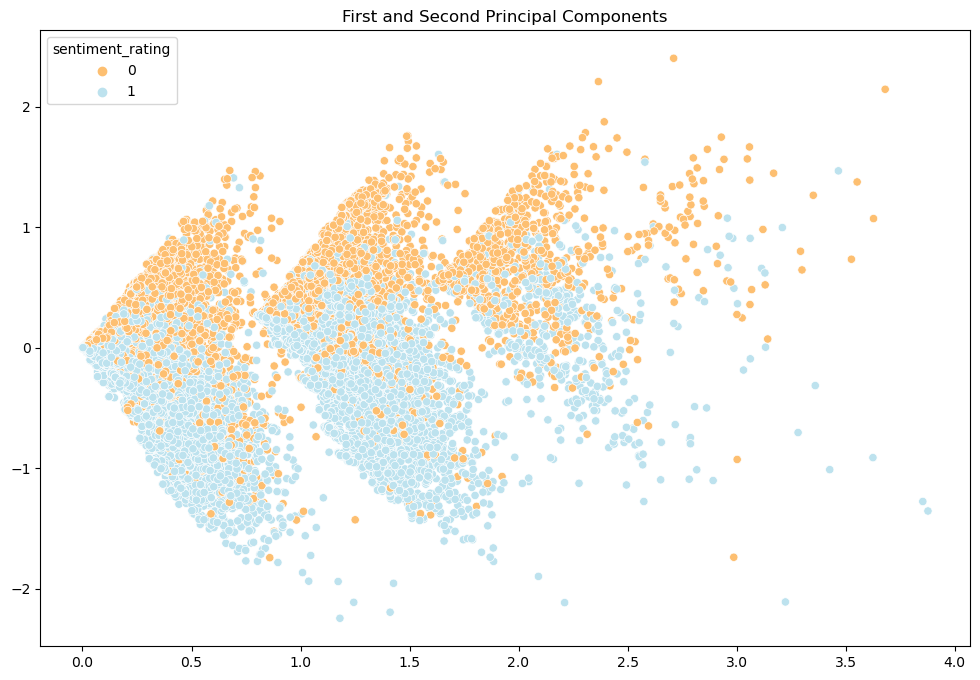

In [55]:
# Use TruncatedSVD 
svd = TruncatedSVD(n_components=2)
X_count_svd = svd.fit_transform(co_data)
y_count = order_reviews_data_message_dropna.sentiment_rating
plt.figure(figsize=(12,8))
sns.scatterplot(x=X_count_svd[:,0], y=X_count_svd[:,1], hue=y_count, palette='RdYlBu', legend='full')
plt.title('First and Second Principal Components')
plt.show();

The scatterplot shows the separation distance between feature vectors. We can see a clear separation between positive and negative sentiment data points; however, there is some overlap between the positive and negative sentiment classes. This means that the sentiment classifier could not _completely_ separate the positive and negative sentiments based on the extracted features. However, for this assignment, the results are satisfactory.

<a id="4b"></a>
### d.ii) Sentiment Classifier ###

The next step is to split the data into training and testing sets and train a classification model on the training data. Common ML algorithms used for sentiment analysis include logistic regression, naive Bayes, and support vector machines. 

A sentiment classifier is a machine-learning model that predicts the sentiment of a given text. It is trained on a dataset of labelled examples, where each example is associated with a sentiment label (positive, negative, etc.). The classifier uses this training data to learn patterns in the text associated with different sentiment labels and then applies these patterns to new, unseen text to predict its sentiment. 

The group decided to use **Logistic Regression** to solve the classification problem, as it generally has better results, especially when large datasets are used.

In [56]:
# Split the sentiment scores column into train/test
X_train_co, X_test_co, y_train_co, y_test_co = train_test_split(co_data,
                                                                    order_reviews_data_message_dropna['sentiment_rating'],
                                                                    test_size = 0.2,
                                                                    random_state = 42)

# Compute the proportion of positive and negative sentiments
y_test_co.value_counts()/y_test_co.shape[0]

1    0.694459
0    0.305541
Name: sentiment_rating, dtype: float64

We can see that about 70% of sentiments are classified as positive, and 30% of sentiments are classified as negative, which is to be expected based on the extensive exploratory analysis of the reviews dataset.

Next, we will define and train a **logistic regression model** on the training data (X_train_co and y_train_co), with the max_iter parameter to set the maximum number of iterations for the solver to converge - 200. Then, we will calculate the F1 score by comparing the predicted values with the actual values in y_test_co. 

In [65]:
# Define and train the model
lr_model = LogisticRegression(max_iter = 200)
lr_model.fit(X_train_co, y_train_co)

# Predict results
test_pred = lr_model.predict(X_test_co)

# Calculate F1 score and print
f1score = f1_score(y_test_co,test_pred)

# Create confusion matrix
cm = confusion_matrix(y_test_co, test_pred)

# Calculate precision
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])

# Calculate recall
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])

# Calculate accuracy
accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)

# Print results
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 score: ", f1score)

LogisticRegression(max_iter=200)

Precision: 0.9374301675977653
Recall: 0.9517867271695972
Accuracy: 0.9224002100840336
F1 score:  0.9445538981142696


Precision, recall, accuracy and F1 score methods were used to evaluate the model's performance. However, they might not be the best methods as the suspiciously high results are most probably caused by class imbalance. There were significantly more positive sentiments than negative sentiments in the dataset, leading to an uneven distribution between the classes. This can lead to overestimating the model's performance, as the model may be simply predicting the majority class. Therefore, alternative evaluation methods that are more suitable for imbalanced datasets, such as AUC-ROC, will be used to better assess the performance of the model.

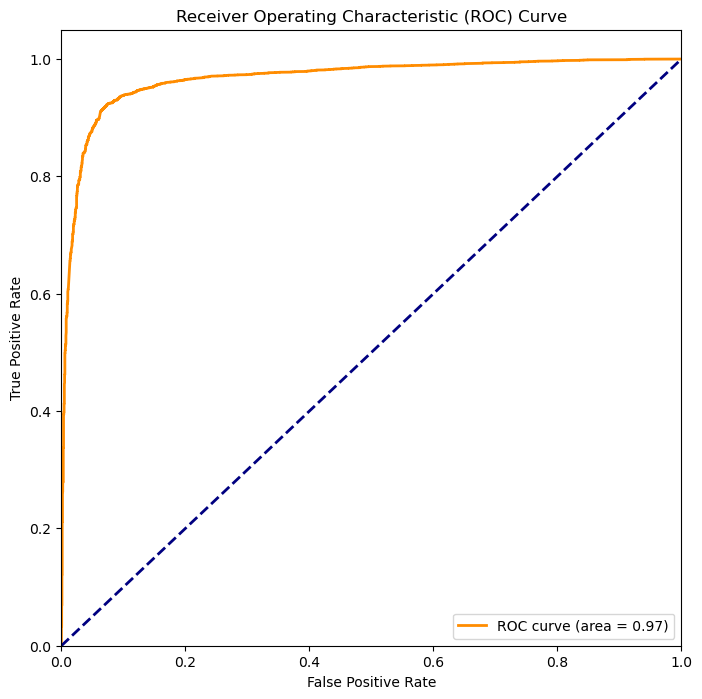

In [67]:
# Plot ROC curve
y_pred_prob = lr_model.predict_proba(X_test_co)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_co, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show();

From the ROC curve above, we can see that the model is indeed of high quality.

<a id="4c"></a>
### d.iii) Results and Visualisation ###

Next, we will extract the top 20 important n-grams for positive sentiment based on the logistic regression model trained on a bag-of-words representation of customer reviews. We will create a new data frame (lr_weights) by zipping the n-gram feature names and their corresponding logistic regression coefficients. Then, we are sorting the data frame in descending order by the logistic regression coefficients to get the n-grams with the highest weights, which indicate the most important features for positive sentiment. Finally, we are extracting the top 20 n-grams with the highest weights.

In [58]:
# Extract top 20 most important n-grams for positive sentiment
lr_weights = pd.DataFrame(list(zip(co_counts.get_feature_names_out(), # get all the n-gram feature names
                                   lr_model.coef_[0])), # get the logistic regression coefficients
                          columns = ['words','weights']) # define the colunm names
positive_sentiments = pd.DataFrame(lr_weights.sort_values(['weights'], ascending = False)[:20]) # top 20 features for positive reviews

# Print results
positive_sentiments

words   weights
127689                fast  3.110632
5512                agreat  3.013628
26371                avery  2.788461
146745               great  2.781036
120255           excellent  2.731093
184213               loved  2.675680
225007             perfect  2.537781
141278                good  2.454888
266590             quickly  2.208440
207721                  ok  2.205251
69195      congratulations  2.178606
89573   delivered deadline  2.151676
291390           satisfied  2.121210
30688            beautiful  2.029610
286664               right  2.027578
183809                love  1.987175
118116          everything  1.899416
364822           wonderful  1.863081
359199                well  1.847926
178087               liked  1.826965

Next, we will do the same for negative sentiments.

In [59]:
# Top 20 features for negative reviews
negative_sentiments = pd.DataFrame(lr_weights.sort_values(['weights'], ascending = False)[-20:])

# Print results
negative_sentiments

words   weights
185647             low -1.602222
76548             crap -1.607620
217947         overdue -1.639698
64373         comments -1.641940
106420    dissatisfied -1.666730
102479      didnt like -1.713388
86592        defective -1.722341
87768          deliver -1.742669
173122            late -1.747381
309784            slow -1.748182
352348         waiting -1.871334
223226          passed -1.904852
269503         receive -1.940694
170113            lack -1.994949
108710  dont recommend -2.012344
192484            meet -2.065701
105374    disappointed -2.258777
27832              bad -2.330718
232488            poor -2.356566
328329        terrible -2.531689

We will now visualise the top 20 positive and negative sentiments using a bar chart.

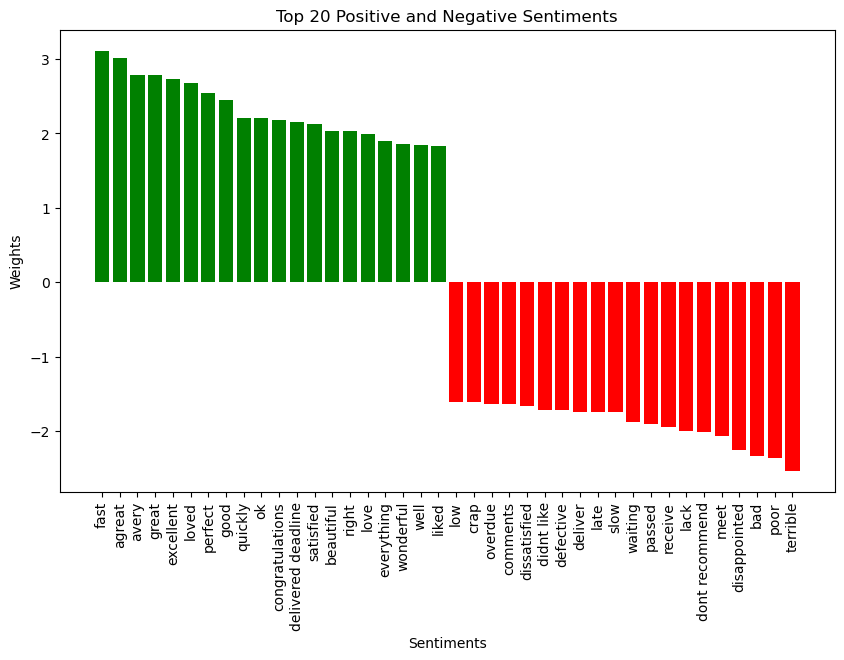

In [61]:
# Set up the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the top 20 positive sentiments
ax.bar(positive_sentiments['words'], positive_sentiments['weights'], color='green')

# Plot the top 20 negative sentiments
ax.bar(negative_sentiments['words'], negative_sentiments['weights'], color='red')

# Set the axis labels and title
ax.set_xlabel('Sentiments')
ax.set_ylabel('Weights')
ax.set_title('Top 20 Positive and Negative Sentiments')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.show();

_[Go to top](#top-of-page)_

<a id="2-conclusion"></a>
# 2. Subtask 5: Conclusion #


In this subtask, the group performed some additional exploratory data analysis of the customer review dataset, including gaining insights into word counts and words used per review score. We also used **Word Clouds** to visualise the language used and extracted a **group of words** (one, two and three-word groups) to better understand the review-writing patterns of satisfied and unsatisfied customers.

Next, we extracted features and fitted the model with clean and pre-processed data, at which point the group decided to exclude 3-star reviews as they are negative and only use 'negative' (1 & 2-star reviews) and 'positive' (4 & 5-star reviews) sentiments. Then, the **Bag-of-Words (BoW)** and the **Count Vectorization** techniques were used to convert the data into numerical features for the chosen algorithm. Then, the **TruncatedSVD (Singular Value Decomposition)** was applied to reduce the size of the feature vectors to improve the accuracy of the model and make visualisation easier.

To solve the Sentiment Classifier, the group decided to use **Logistic Regression**, as it generally produces better results, especially when large datasets are used. The model's score was calculated to be 0.94, which means the model was successful and had reliable results.

At last, we extracted the top 20 most important n-grams for positive and negative sentiments based on the predictive model and used their corresponding logistic regression coefficients to visualise them using a bar plot.

The Sentiment Analysis outputs and knowledge can be used to:
* **Improve customer satisfaction**: The business can use the identified n-grams to understand what customers are positively mentioning in their reviews. This can help the business to identify the aspects of their product or service that are working well and what the customers value the most. This information can then be used to improve the business's product or service and increase customer satisfaction.
* **Marketing**: The business can use the identified n-grams to create marketing materials, such as social media posts or advertisements, that highlight the positive aspects of their product or service. This can help to attract new customers who are looking for those features.
* **Competitor analysis**: The business can compare the identified n-grams with those of their competitors. This can help the business to identify what the competitors are doing well and what their customers are happy with. This information can be then used to improve the business's product or service and differentiate themselves from the competitors.
* **Further analysis**: The business can conduct further analysis to understand how the identified n-grams are related to other variables, such as demographics or purchase history. This can provide deeper insights into customer preferences and help the business to tailor their product or service to better meet the customers' needs.
<br>_[Go to top](#top-of-page)_

<a id="3-references"></a>
# 3. References #

Li, S. (2018) A Beginner’s Guide on Sentiment Analysis with RNN. Towards Data Science. Available from: https://medium.com/towards-data-science/a-beginners-guide-on-sentiment-analysis-with-rnn-9e100627c02e [Accessed 01 May 2023]
Gupta, S. (2018) Sentiment Analysis: Concept, Analysis and Applications. Towards Data Science. Available from: https://medium.com/towards-data-science/sentiment-analysis-concept-analysis-and-applications-6c94d6f58c17 [Accessed 01 May 2023]

<a id="4-conclusion"></a>
# 4. Overall Conclusion of the Project #

In conclusion, this report explored the challenges and opportunities in solving business intelligence and data mining problems, focusing on using recommender systems to analyse customer behaviour and make personalised product recommendations. We built and evaluated a shopping recommender system that could identify user preferences based on their shopping history and recommend products accordingly.

The report consisted of five subtasks: exploratory data analysis, customer segmentation, building a shopping recommender system, evaluating its effectiveness, and sentiment analysis. The exploratory data analysis provided valuable insights into Olist's operations and customer behaviour, which guided further analysis and decision-making in the subsequent subtasks. The insights derived from customer segmentation using the RFM method will help develop strategies to enhance the platform's overall performance and improve customer satisfaction.

We built the shopping recommender system using collaborative filtering techniques, which proved to be an effective model for recommending products to customers based on their purchasing history and the purchasing history of similar customers. The system incorporated the insights gained from customer segmentation to provide personalised recommendations that are more likely to be relevant to each customer group's needs and preferences. Evaluating the recommender system's effectiveness using appropriate metrics such as AUC, precision, recall, and f1 showed promising results, indicating that it can increase the likelihood of customer engagement and loyalty, ultimately leading to increased sales and revenue.
As a bonus task, we explored the use of sentiment analysis to extract additional intelligence about the dataset, which could be used to identify customer satisfaction trends and improve overall customer experience. The results indicated that the sentiment towards Olist was generally positive, with a few negative reviews related to product quality and delivery times.

Overall, this report demonstrated the potential of using data mining and business intelligence techniques to gain valuable insights into customer behaviour and improve business performance. The findings can guide decision-making, enhance the platform's overall performance, and improve customer satisfaction, leading to increased sales and revenue.

<br>_[Go to top](#top-of-page)_

End of subtask 5<br>
End of project